# Melhorando resolução de imagens com Deep Learning

## Criando rede neural para melhorar resolução de imagens, reduzindo 'ruídos' em imagem

In [1]:
import tensorflow as tf
import plotly.express as px
from plotly.subplots import make_subplots
import os
import cv2

In [ ]:
os.chdir('/kaggle/input/caltech101')

In [ ]:
classes = os.listdir('101_ObjectCategories')
arrays = []
for x in classes:
    print(x)
    for y in os.listdir('101_ObjectCategories/' + x):
        print(y)
        image = cv2.imread('101_ObjectCategories/' + x + '/' + y)
        if len(image.shape) == 2:
            image = tf.expand_dims(image, axis = -1)
            image = tf.image.resize(image, (256, 256))
            image = tf.expand_dims(image, axis = 0) #4D
            image = tf.cast(image, tf.float32) / 255
            arrays.append(image)
        elif len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            image = tf.expand_dims(image, axis = -1)
            image = tf.image.resize(image, (256, 256))
            image = tf.expand_dims(image, axis = 0) #4D
            image = tf.cast(image, tf.float32) / 255
            arrays.append(image)

In [ ]:
dataset = tf.concat(arrays, axis = 0)
dataset.shape

In [ ]:
percentage = int(510*0.8) #80%
x_train = dataset[:percentage]
x_test = dataset[percentage:]
print(x_train.shape)
print(x_test.shape)

In [ ]:
x_train_noisy = tf.random.normal(shape = x_train.shape, mean = 0.5, stddev = 0.5)
x_test_noisy = tf.random.normal(shape = x_test.shape, mean = 0.5, stddev = 0.5)
print(x_train_noisy.shape)
print(x_test_noisy.shape)

In [ ]:
x_train_noisy = tf.clip_by_value(x_train + x_train_noisy, 0, 1)
x_test_noisy = tf.clip_by_value(x_test + x_test_noisy, 0, 1)

In [2]:
class ConvolutionalAutoEncoder:
    def __init__(self):
        return 

    def _build_autoencoder(
        self, 
        input_shape = (256,256,1)):
        #Encoder
        self.enc_input = tf.keras.layers.Input(shape = (256,256,1))
        self.l1 = tf.keras.layers.Conv2D(
            64, 
            (3,3), 
            padding = 'same', 
            #kernel_initializer = 'he_uniform', 
            activation = 'relu', 
            activity_regularizer = tf.keras.regularizers.l1(10e-10))(self.enc_input)
        self.l2 = tf.keras.layers.Conv2D(
            64, 
            (3,3), 
            padding = 'same', 
            #kernel_initializer = 'he_uniform', 
            activation = 'relu', 
            activity_regularizer = tf.keras.regularizers.l1(10e-10))(self.l1)
        self.l3 = tf.keras.layers.MaxPooling2D(padding = 'same')(self.l2)
        self.l4 = tf.keras.layers.Conv2D(
            128, 
            (3,3), 
            padding = 'same', 
            #kernel_initializer = 'he_uniform', 
            activation = 'relu', 
            activity_regularizer = tf.keras.regularizers.l1(10e-10))(self.l3)
        self.l5 = tf.keras.layers.Conv2D(
            128, 
            (3,3), 
            padding = 'same', 
            #kernel_initializer = 'he_uniform', 
            activation = 'relu', 
            activity_regularizer = tf.keras.regularizers.l1(10e-10))(self.l4)
        self.l6 = tf.keras.layers.MaxPooling2D(padding = 'same')(self.l5)
        self.l7 = tf.keras.layers.Conv2D(
            256, 
            (3,3), 
            padding = 'same', 
            #kernel_initializer = 'he_uniform', 
            activation = 'relu', 
            activity_regularizer = tf.keras.regularizers.l1(10e-10))(self.l6)
        self.l8 = tf.keras.layers.UpSampling2D()(self.l7)
        #Decoder
        self.l9 = tf.keras.layers.Conv2D(
            128, 
            (3,3), 
            padding = 'same', 
            #kernel_initializer = 'he_uniform', 
            activation = 'relu', 
            activity_regularizer = tf.keras.regularizers.l1(10e-10))(self.l8)
        self.l10 = tf.keras.layers.Conv2D(
            128, 
            (3,3), 
            padding = 'same', 
            #kernel_initializer = 'he_uniform', 
            activation = 'relu', 
            activity_regularizer = tf.keras.regularizers.l1(10e-10))(self.l9)
        self.l11 = tf.keras.layers.add([self.l10, self.l5])
        self.l12 = tf.keras.layers.UpSampling2D()(self.l11)
        self.l13 = tf.keras.layers.Conv2D(
            64, 
            (3,3), 
            padding = 'same', 
            #kernel_initializer = 'he_uniform', 
            activation = 'relu', 
            activity_regularizer = tf.keras.regularizers.l1(10e-10))(self.l12)
        self.l14 = tf.keras.layers.Conv2D(
            64, 
            (3,3), 
            padding = 'same', 
            #kernel_initializer = 'he_uniform', 
            activation = 'relu', 
            activity_regularizer = tf.keras.regularizers.l1(10e-10))(self.l13)
        self.l15 = tf.keras.layers.add([self.l14, self.l2])
        self.dec_output = tf.keras.layers.Conv2D(
            1,
            (3,3),
            padding = 'same',
            #kernel_initializer = 'he_uniform',
            activation = 'relu',
            activity_regularizer = tf.keras.regularizers.l1(10e-10))(self.l15)
        self.autoencoder = tf.keras.models.Model(inputs = (self.enc_input), outputs = self.dec_output)
        return self.autoencoder
        

    def fit(self, x_train, x_train_noisy, x_test, x_test_noisy):
        self.autoencoder = self._build_autoencoder()
        self.autoencoder.compile(
            optimizer = 'adam',
            loss = 'mse',
            metrics = ['accuracy'])
        self.autoencoder.fit(
            x_train_noisy, 
            x_train, 
            epochs = 15, 
            batch_size = 16, 
            shuffle = True, 
            validation_data = (x_test_noisy, x_test))
        return self.autoencoder

In [3]:
cae = ConvolutionalAutoEncoder()

2022-01-09 17:21:55.489896: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


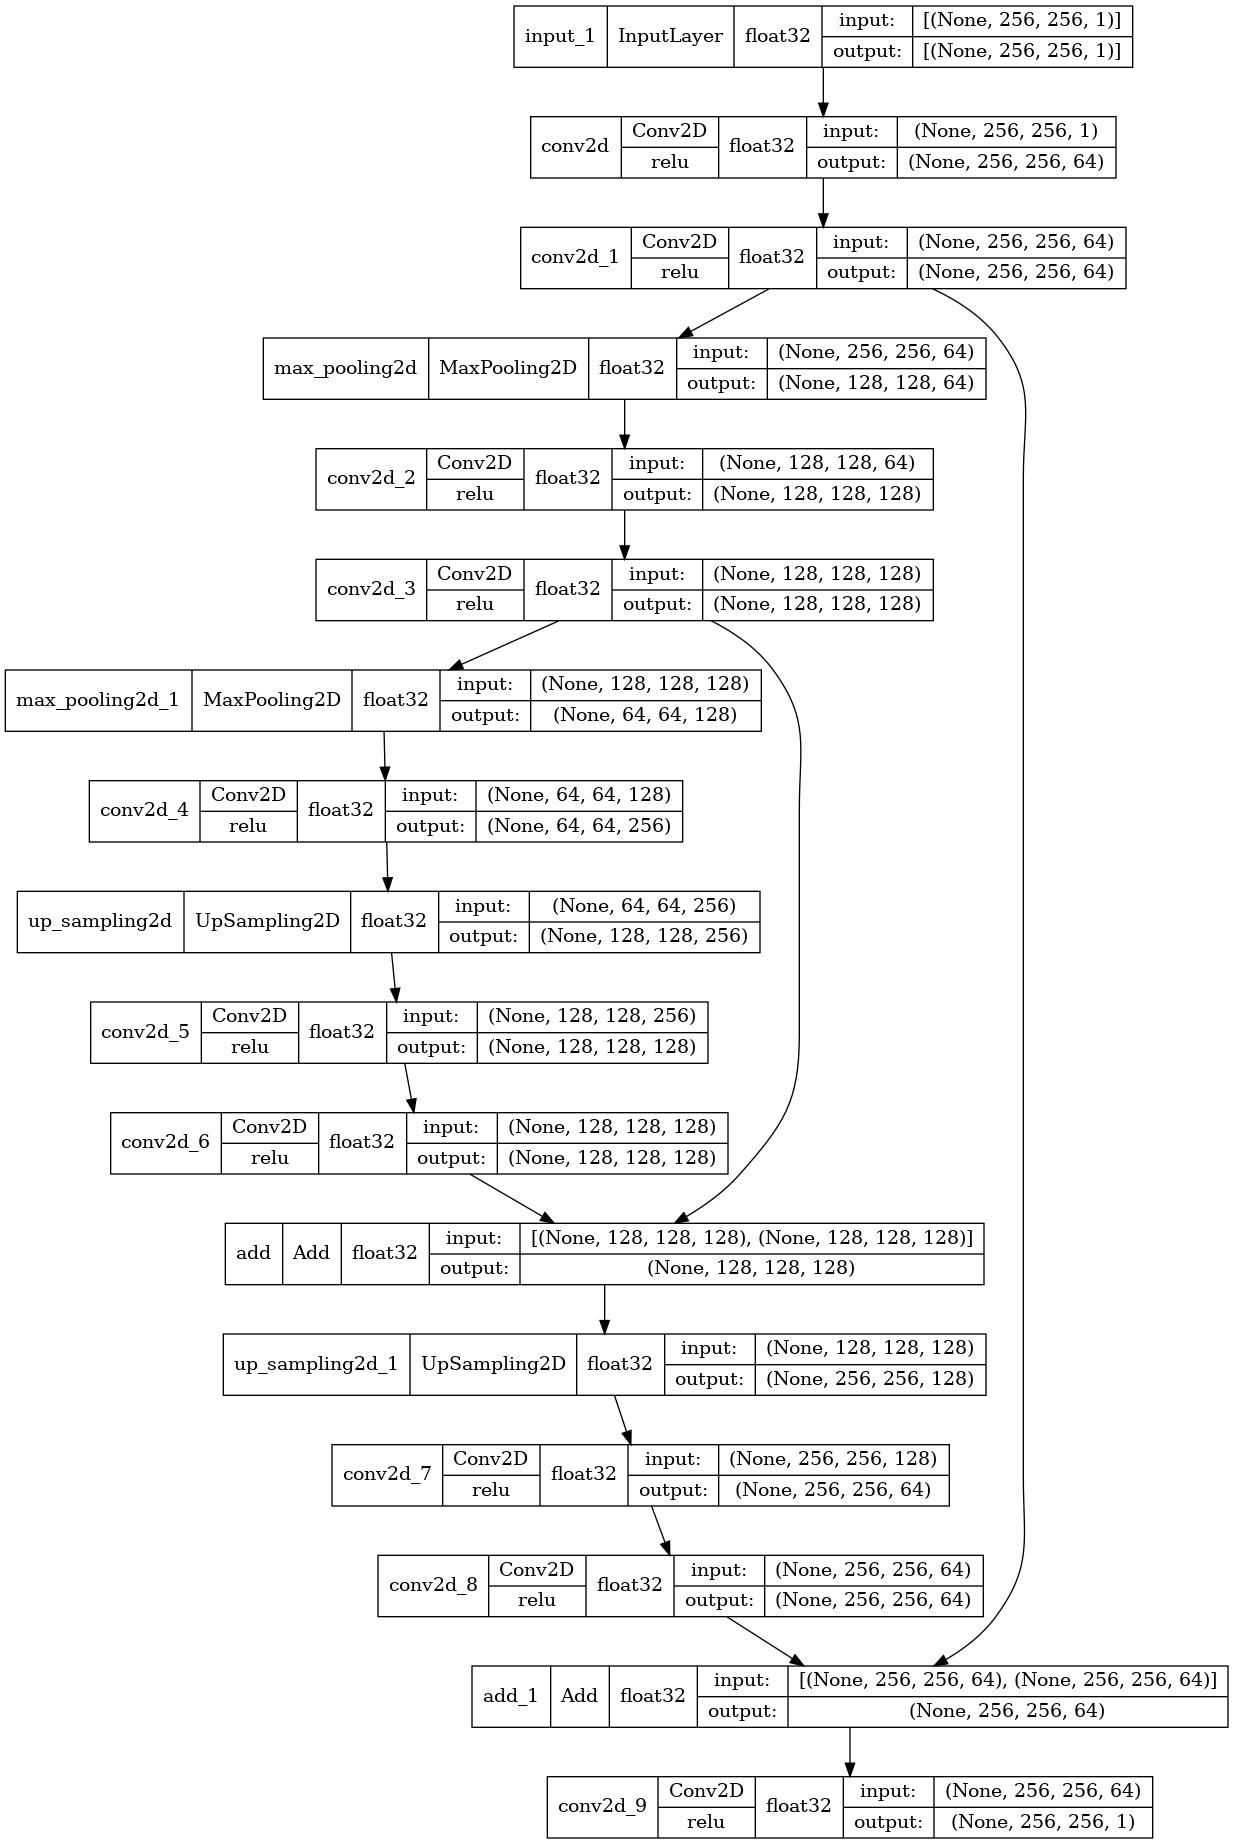

In [4]:
model = cae._build_autoencoder()
tf.keras.utils.plot_model(
    model, 
    'images/ConvolutionalAutoEncoder.jpg', 
    show_shapes = True, 
    show_dtype = True, 
    show_layer_activations = True)

In [ ]:
autoencoder = cae.fit(x_train, x_train_noisy, x_test, x_test_noisy)

In [ ]:
def show_image(image):
    image = tf.expand_dims(image, axis = 0)
    pred = autoencoder(image)
    image = cv2.cvtColor(image[0].numpy(), cv2.COLOR_GRAY2RGB)
    pred = cv2.cvtColor(pred[0].numpy(), cv2.COLOR_GRAY2RGB)
    subplots = make_subplots(rows = 1, cols = 2)
    fig1 = px.imshow(image)
    fig2 = px.imshow(pred)
    subplots.add_trace(fig1.data[0], row = 1, col = 1)
    subplots.add_trace(fig2.data[0], row = 1, col = 2)
    subplots.show()

In [ ]:
image = x_test[9]
show_image(image)

In [ ]:
autoencoder.save('model.h5')